# Imports

In [66]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Dowanload and load catalan stopwords from `spacy`.

In [3]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

  Using cached https://github.com/explosion/spacy-models/releases/download/ca_core_news_sm-3.8.0/ca_core_news_sm-3.8.0-py3-none-any.whl (19.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'altres', 'eres', 'saben', 'mon', 'estic', "t'ha", 'estaven', 'meves', 'què', 'propi', 'meus', 'han', 'molts', 'puc', 'cadascuna', 'les', 'mentre', 'meu', 'ne', 'us', 'és', 'ja', 'pels', 'pocs', 'teu', 'últim', 'llarg', 'cada', 'només', 'em', 'mons', 'està', 'o', 'on', 'havia', 'aquest', "s'han", 'tinc', 'sa', 'als', 'anar', 'fa', 'faig', 'hi', "d'una", 'encara', 'aquella', 'sóc', 'quelcom', 'ser', 'tenim', "l'hi", 'poques', 'tenir', 'consegueixo', 'quan', 'va', 'la', 'unes', 'éssent', 'semblant', 'son', 'aquests', 'en', 'nostra', 'sons', 'es', 'aquí', 'els', 'però', 'dels', 'donat', 'allò', 'no', 'oh', 'estem', 'molt', 'primer', "li'n", 'quins', 'tampoc', 'veu', 'soc', 'algun', 'quin', 'cadascunes', 'contra', 'abans', 'poca', 'seva', 'vaig'

# Load and process csv data

In [4]:
data = pd.read_csv('../data/train.csv')

In [5]:
texts = data['text']
labels = data['class']
year = data['year']

## Remove stopwords + leading and trailing quotes

In [9]:
def remove_stopwords(sentence):
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords])

    return sentence

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(remove_stopwords(sentence))

In [11]:
for sentence in preprocessed_texts:
    if sentence.startswith(("'", '"')):
        sentence = sentence[1:]
    if sentence.endswith(("'", '"')):
        sentence = sentence[:-1]

In [12]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

["Aprovació definitiva projecte bombament clavegueram l'Institut Baix Montseny camp futbol Can Sans."
 "Convocatòria subvencions l'àmbit esportiu d'activitats 2016."
 "Aprovació definitiva modificació crèdit 04/2018 pressupost general Diputació Barcelona l'exercici 2018."
 "Convocatòria concurs Cartells Dia Internacional Dones, l'any 2020."
 "Aprovació inicial modificació l'Ordenança reguladora preus públics."
 "Delegació d'alcalde accidental dies 29 maig 1 juny 2015, inclosos."
 "Subvenció pagament l'impost béns immobles (IBI) any 2019."
 "Baixa Padró Municipal d'Habitants."
 'Citació notificació mitjançant compareixença.'
 "Licitació concessió administrativa l'ús privatiu d'espais domini públic l'explotació mòdul 3 polivalent ubicat Parc Joan Maragall Caldes d'Estrac."
 "Adjudicació formalització contracte prestació serveis postals l'Ajuntament."
 "Delegacions d'Alcaldia regidor."
 'Nomenament personal funcionari carrera.'
 "Licitació contracte d'obres Nova escola bressol: finalitzac

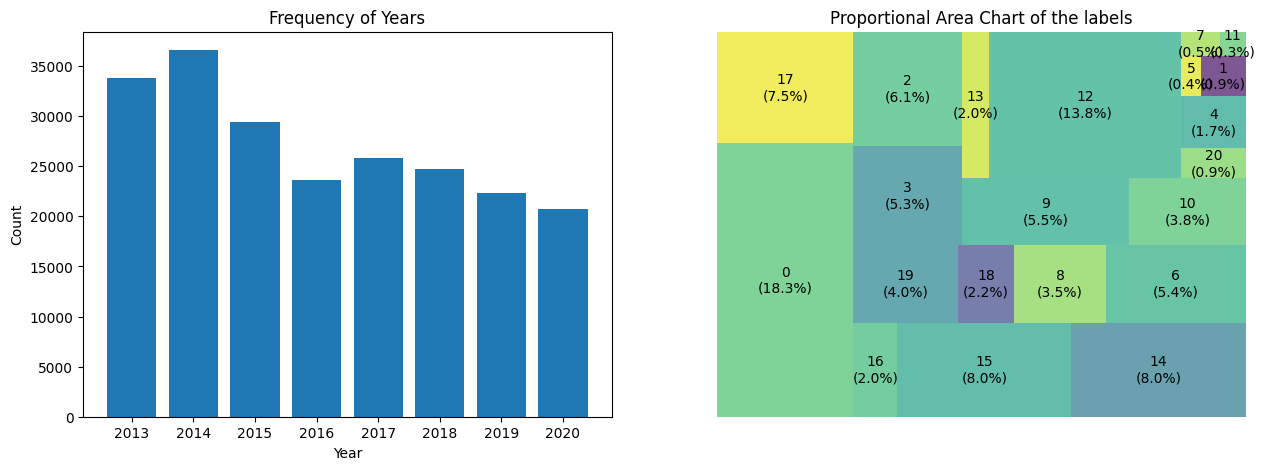

In [64]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Convert texts to TF-IDF vectors

In [14]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [15]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [16]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [17]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

## Training and Testing

In [18]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for step, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(data), len(train_loader.dataset),
                100. * step / len(train_loader), loss.item()))

In [19]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).item() * target.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [20]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train(fcnn, train_dataset, optimizer, epoch)
    test(fcnn, test_dataset)

Train Epoch: 1 [0/151881 (0%)]	Loss: 3.045285
Train Epoch: 1 [3200/151881 (2%)]	Loss: 1.659530
Train Epoch: 1 [6400/151881 (4%)]	Loss: 0.800069
Train Epoch: 1 [9600/151881 (6%)]	Loss: 0.381011
Train Epoch: 1 [12800/151881 (8%)]	Loss: 0.414087
Train Epoch: 1 [16000/151881 (11%)]	Loss: 0.458306
Train Epoch: 1 [19200/151881 (13%)]	Loss: 0.380540
Train Epoch: 1 [22400/151881 (15%)]	Loss: 0.164928
Train Epoch: 1 [25600/151881 (17%)]	Loss: 0.217871
Train Epoch: 1 [28800/151881 (19%)]	Loss: 0.135074
Train Epoch: 1 [32000/151881 (21%)]	Loss: 0.268345
Train Epoch: 1 [35200/151881 (23%)]	Loss: 0.304954
Train Epoch: 1 [38400/151881 (25%)]	Loss: 0.245023
Train Epoch: 1 [41600/151881 (27%)]	Loss: 0.156764
Train Epoch: 1 [44800/151881 (29%)]	Loss: 0.371206
Train Epoch: 1 [48000/151881 (32%)]	Loss: 0.452811
Train Epoch: 1 [51200/151881 (34%)]	Loss: 0.323723
Train Epoch: 1 [54400/151881 (36%)]	Loss: 0.161352
Train Epoch: 1 [57600/151881 (38%)]	Loss: 0.315475
Train Epoch: 1 [60800/151881 (40%)]	Loss: 0